In [220]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import exists

In [221]:
folder = './cv2019_data/calib/'
files = [f'{folder}{f}' for f in os.listdir(folder)]

cameraParameters = './res/params.npz'
LOAD_PARAMETERS = True # if true load parameters from file (if it exists) else computes params from the images

# Finding camera parameters

In [222]:
if LOAD_PARAMETERS and exists(cameraParameters):
    params = np.load(cameraParameters)
    mtx = params['mtx']
    dist = params['dist']
    newcameramtx = params['newcameramtx']
    roi = params['roi']

    print('Camera parameters loaded from file')
else:
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    objp = np.zeros((5*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:5].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    for c, f in enumerate(files):
        img = cv.imread(f)
        gImg = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

        ret, corners = cv.findChessboardCorners(gImg, (7,5), None)

        if ret == True:
            objpoints.append(objp)

            corners2 = cv.cornerSubPix(gImg, corners, (11,11), (-1, -1), criteria)
            imgpoints.append(corners)

            img = cv.drawChessboardCorners(img, (7,5), corners2, ret)
            
            # plt.imshow(img)
            # plt.show()

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gImg.shape[::-1], None, None)

    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    np.savez(cameraParameters, mtx = mtx, dist = dist, newcameramtx = newcameramtx, roi = roi)




Loaded camera param


## Undistort image

In [223]:
def undistort(img, useRoi=True, plotBeforeAndAfter=False):
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)

    if useRoi:
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w] # removes black part of the image

    # Plot before and after
    if plotBeforeAndAfter:
        cv.imwrite('./res/calibresult.png', dst)

        fig = plt.figure(figsize=(10, 5))

        fig.add_subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Before')

        fig.add_subplot(1, 2, 2)
        plt.imshow(dst)
        plt.axis('off')
        plt.title('After')

    return dst


## Compute Homography

Notes:
- **findContours**: gives a connected contour, Canny instead gives just edges lines that are not necessarily connected
- **approxPolyDP**: It approximates a contour shape to another shape with less number of vertices depending upon the precision we specify (it is an implementation of Douglas-Peucker algorithm.). The second argument is called epsilon, which is maximum distance from contour to approximated contour.
- **arcLength**: contour perimeter, second argument specify wether shape is a closed contour (True) or just a curve (False)

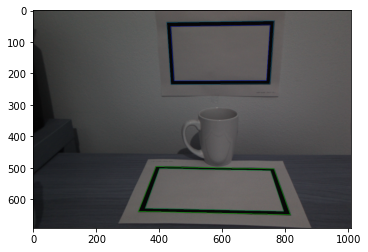

In [230]:
# Epsilon is the minimum size in pixel
#! Deprecated in favor of simple perimeter length
def isBigEnough(contour, epsilon=20):
    maxX = np.max(contour[:, 0, 0], axis=0)
    minX = np.min(contour[:, 0, 0], axis=0)
    maxY = np.max(contour[:, 0, 1], axis=0)
    minY = np.min(contour[:, 0, 1], axis=0)

    return maxX - minX > epsilon and maxY - minY > epsilon


def findPlanes(frame, preciseCorners=True):
    frame = undistort(frame)
    gFrame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    r, tFrame = cv.threshold(gFrame, 15, 255, cv.THRESH_BINARY)
    _, contours, _ = cv.findContours(tFrame,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    colorG = 255
    colorR = 0

    for contour in contours:
        perimeter = cv.arcLength(contour,True)
        epsilon = 0.005*perimeter
        approx = cv.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4 and perimeter > 20:
            
            if preciseCorners:
                corners = cv.cornerSubPix(tFrame, np.float32(approx), (4,4), (-1, -1), criteria)
                corners = np.int64(corners)

                frame = cv.drawContours(frame, [corners], -1, (0, colorG, colorR))
            else:
                frame = cv.drawContours(frame, [approx], -1, (0, colorG, colorR))
            

            colorG -= 75
            colorR += 75
    
    plt.imshow(frame)
    plt.show()
    outName = './res/planes_precise.png' if preciseCorners else './res/planes_approx.png'
    cv.imwrite(outName, frame)


vid = cv.VideoCapture('./cv2019_data/cup1.mp4')
ret, frame = vid.read()

if ret:
    findPlanes(frame, preciseCorners=True)